# Plot differences between epochs 
#### From files in ./analogue_data/analogue_differences

### Functions

In [49]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python')                   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

### Directories

In [50]:
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA-Land/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'
diff_dir = './analogue_data/analogue_differences/' 

### Variable

In [51]:
# Variable
var_analogues = 'psl'  # Variable used to find the analogues, e.g. 'psl' for sea level pressure
varname = 'pr'  # Variable to compute the difference between analogues, e.g. 'zg' for geopotential height

### Event

In [52]:
# Event
lselect = 'alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
event_origin = 'CRCM5-LE'  # 'ERA5' or 'CRCM5-LE'
if event_origin == 'ERA5':
    str_event = f'node{no_node}-extreme{no_event}-{lselect}'
elif event_origin == 'CRCM5-LE':
    str_event = f'BAM-node{no_node}-extreme{no_event}-{lselect}'
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

### Analogue selection

In [53]:
# Quantile
qtl_LE = 0.99

# Number of ensemble members
no_membs = 1
# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + 'psl') if os.path.isdir(os.path.join(CRCM5_dir + 'psl', name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members

# Epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)

# Difference between epochs
list_diff_indices = [[0,1],[0,2],[1,2]]  # Define the indices of epochs to compare

### Upload Euclidean distance of analogues from event

In [54]:
# Load ensemble data
ensemble_data = []
for i, year_range in enumerate(list_year_ranges):
    epoch_data = {}
    for memb in list_membs:
        # Construct the file path
        if event_origin == 'ERA5':
            file_path = f'./analogue_data/times_distances_analogues-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5-LE_memb-{memb}.npz'
        elif event_origin == 'CRCM5-LE':
            file_path = f'./analogue_data/times_distances_analogues-{var_analogues}_BAM-node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5-LE_memb-{memb}.npz'
        # Load the data from the npz file
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        # Load the data
        data = np.load(file_path, allow_pickle=True)
        times = data['times']
        distances = data['distances']
        epoch_data[memb] = {'times': times, 'distances': distances}
    ensemble_data.append(epoch_data)
no_analogues_LE = len(ensemble_data[0][list_membs[0]]['times'])  # Number of analogues per member

# Load ERA5 data
file_path_ERA5 = f'./analogue_data/times_distances_analogues-mslp_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_2004-2023_ERA5.npz'
if not os.path.exists(file_path_ERA5):
    print(f"File not found: {file_path_ERA5}")
# Load the data
data_ERA5 = np.load(file_path_ERA5, allow_pickle=True)

In [55]:
# Distance from event
# CRCM5-LE distances
list_distances = []  # Initialize distances array for plotting
mean_dist = np.zeros(no_epochs)  # Initialize mean distance array for plotting
for i in range(len(list_year_ranges)):
    distances = np.zeros((no_membs, no_analogues_LE))  # Initialize distances array for plotting
    for im, memb in enumerate(list_membs):
        # Extract distances for the current member and epoch
        distances[im] = ensemble_data[i][memb]['distances']
    list_distances.append(distances)  # Append distances for the current epoch
    mean_dist[i] = np.mean(distances)  # Calculate mean distance for the current epoch

# ERA5 distances
distances_ERA5 = data_ERA5['distances']

### Plot distance from event in the different epochs

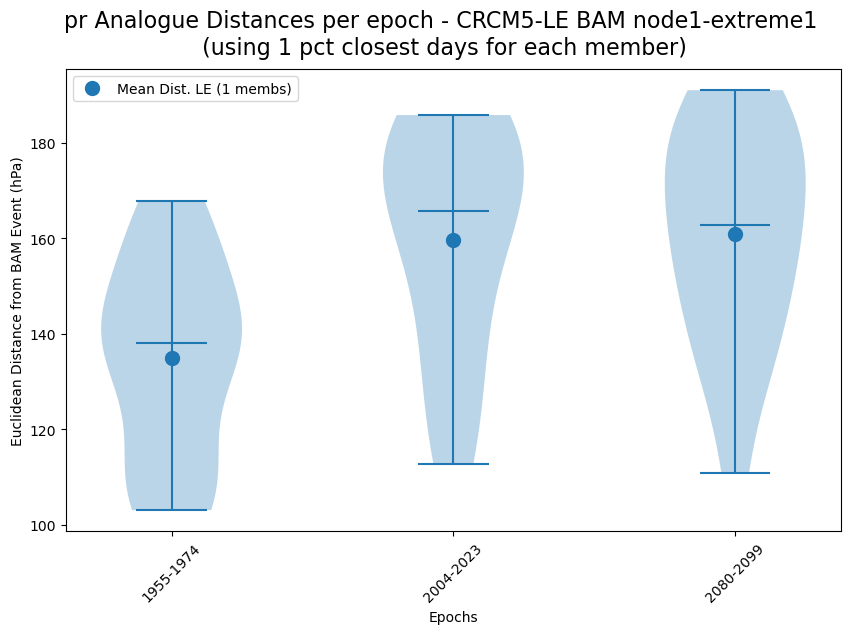

In [56]:

# Plot distance from event in the different epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
if event_origin == 'ERA5':
    fig.suptitle(f"{varname} Analogue Distances per epoch - ERA5 event node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16) 
elif event_origin == 'CRCM5-LE':
    fig.suptitle(f"{varname} Analogue Distances per epoch - CRCM5-LE BAM node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16)

# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]
# # Plot violin per member
# for im in range(no_membs):
#     dist_per_epoch = [dist_epoch[im] for dist_epoch in list_distances]
#     vp = ax.violinplot(dist_per_epoch, showmeans=False, showmedians=True, showextrema=True)
#     median_color = vp['cmedians'].get_color() 
# Plot violin per epoch
dist_per_epoch = [dist_epoch.flatten() for dist_epoch in list_distances]
vp = ax.violinplot(dist_per_epoch, showmeans=False, showmedians=True, showextrema=True)
median_color = vp['cmedians'].get_color() 
# Plot violin per epoch
# Plot the mean distance for the epoch
ax.plot(np.arange(1,no_epochs+1), mean_dist, marker='o', color=median_color, markersize=10, label=f'Mean Dist. LE ({no_membs} membs)', linewidth=0)

if event_origin == 'ERA5':
    # Plot ERA5 violin
    vp = ax.violinplot(distances_ERA5, positions=[2], showmeans=False, showmedians=True, showextrema=True)
    median_color = vp['cmedians'].get_color() 
    # Plot the mean distance
    ax.plot(2, distances_ERA5.mean(), marker='o', color=median_color, markersize=10, label=f'Mean Dist. ERA5', linewidth=0)

# Ticks and labels
ax.set_xticks(range(1, no_epochs+1))
ax.set_xticklabels(list_epoch_str, rotation=45)
ax.set_xlabel('Epochs')
if event_origin == 'ERA5':
    ax.set_ylabel('Euclidean Distance from ERA5 Event (hPa)')
elif event_origin == 'CRCM5-LE':
    ax.set_ylabel('Euclidean Distance from BAM Event (hPa)')
ax.legend()

# Save the figure
if event_origin == 'ERA5':
    fig.savefig(f"{fig_dir}analogue-distances-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)
elif event_origin == 'CRCM5-LE':
    fig.savefig(f"{fig_dir}BAM-analogue-distances-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)    


### Best analogue in model

In [57]:
ind_member = np.where(list_distances[1]==np.min(list_distances[1]))[0][0]
no_BAM = np.where(list_distances[1]==np.min(list_distances[1]))[1][0]
print('Member and no-analogue:',list_membs[ind_member], no_BAM)  # Example usage of np.argmin to find the index of the minimum distance in the first epoch for the first member
print('Euclidean distance: ', ensemble_data[1][list_membs[ind_member]]['distances'][0])  # Print the shape of the distances array for the first epoch
print('Date:', ensemble_data[1][list_membs[ind_member]]['times'][0])

Member and no-analogue: kba 0
Euclidean distance:  112.64905
Date: 2010-10-30 00:00:00


### Upload difference (+ significance) files

In [58]:
list_ds_diff = []  # List to store difference datasets
list_str_diff = []  # List to store strinlist_membs[19]g representations of differences
list_ds_ks_stats = []  # List to store KS statistics datasets
for i in range(len(list_diff_indices)):
    year_range1 = list_year_ranges[list_diff_indices[i][0]]
    str_year_range1 = "-".join(str(x) for x in year_range1)
    year_range2 = list_year_ranges[list_diff_indices[i][1]]
    str_year_range2 = "-".join(str(x) for x in year_range2)
    list_str_diff.append(f'{str_year_range2} - {str_year_range1}')  # Store the string representation of the difference
    suffix_file = f"_{varname}_{str_event}_{int(100*qtl_LE)}pct_diff{str_year_range2}_{str_year_range1}_CRCM5_{no_membs}membs.nc"
        
    # Load analogue differences
    diff_file = f'{diff_dir}analogues-{var_analogues}_difference{suffix_file}'
    if not os.path.exists(diff_file):
        print(f'File {diff_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_diff = xr.open_dataset(diff_file)
    list_ds_diff.append(ds_diff)
    # Load KS statistics
    significance_file = f'{diff_dir}analogues-{var_analogues}_KS-statistics{suffix_file}'
    if not os.path.exists(significance_file):
        print(f'File {significance_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_ks_stats = xr.open_dataset(significance_file)
    list_ds_ks_stats.append(ds_ks_stats)

### Plot differences

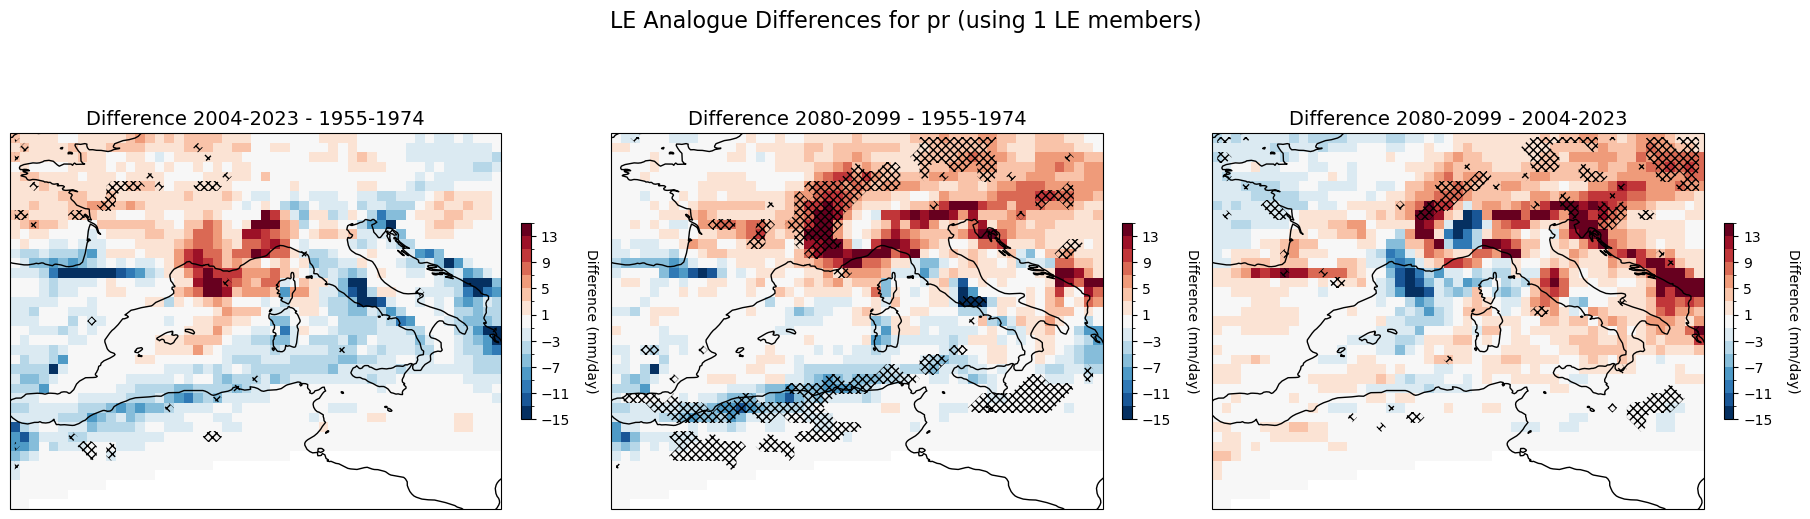

In [59]:
# Create subplots with Cartopy projection
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(18, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)
axes = axes.flatten()

# Colormap and normalization
# Define discrete color levels (e.g., 5 bins from -10 to 10)
if varname == 'psl':
    bounds = np.arange(-3.25, 3.5, .5)  # Bin edges for geopotential height differences
    units = 'hPa'
elif varname == 'zg':
    bounds = np.arange(-15,16,2)  # Bin edges
    units = 'm'
elif varname == 'pr':
    bounds = np.arange(-15,16,2)
    units = 'mm/day'
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

# Define a discrete colormap (must match number of bins)
cmap = plt.get_cmap('RdBu_r', len(bounds) - 1)  # E.g., 6 discrete colors

# Plot each dataset
for i in range(len(list_ds_diff)):
    ax = axes[i]
    ds_diff = list_ds_diff[i][varname].squeeze()  # Extract the variable from the dataset
    ds_pvalue = list_ds_ks_stats[i].sel(output='pvalue').squeeze()

    # Plot assuming ds_diff is 2D (lat, lon)
    if varname == 'zg':
        ds_diff *= 9.8  # Convert geopotential height to hPa
    if varname == 'pr':
        ds_diff *= 3600  # Convert precipitation from m/s*24 to mm/day
    im = ds_diff.plot.imshow(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    # Plot significance using KS statistics
    significant_mask = ds_pvalue[varname].values < 0.05
    # Contour significant areas
    if significant_mask.any():
        ax.contourf(
            ds_diff['lon'], ds_diff['lat'], significant_mask,
            levels=[0.5, 1.5], 
            colors='none',      # no fill color
            hatches=['xxxx'],
            transform=ccrs.PlateCarree()
        )

    # Add map features
    ax.coastlines()
    ax.set_title(f"Difference {list_str_diff[i]}", fontsize=14)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(f'Difference ({units})', rotation=270, labelpad=20)

# Figure title
fig.suptitle(f"LE Analogue Differences for {varname} (using {no_membs} LE members)", fontsize=16)

# Show plot
plt.show()

# Save the figure
fig.savefig(f"{fig_dir}{varname}_analogue-differences-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs_sign.png", bbox_inches='tight', dpi=300)

### Upload anomaly files (abs value for precip)

In [60]:
list_ds_anom = []  # List to store difference datasets
for i in range(len(list_year_ranges)):
    year_range = list_year_ranges[i]
    str_year_range = "-".join(str(x) for x in year_range)
    suffix_file = f"_{varname}_{str_event}_{int(100*qtl_LE)}pct_{str_year_range}_CRCM5_{no_membs}membs.nc"
        
    # Load analogue anomalies
    if varname == 'pr':
        # For precipitation, use the absolute value
        anom_file = f'{diff_dir}analogues-{var_analogues}{suffix_file}'
    else:
        # For other variables, we use the anomalies
        anom_file = f'{diff_dir}analogues-{var_analogues}_anomaly{suffix_file}'
    if not os.path.exists(anom_file):
        print(f'File {anom_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_anom = xr.open_dataset(anom_file)
    list_ds_anom.append(ds_anom)

### Plot anomalies

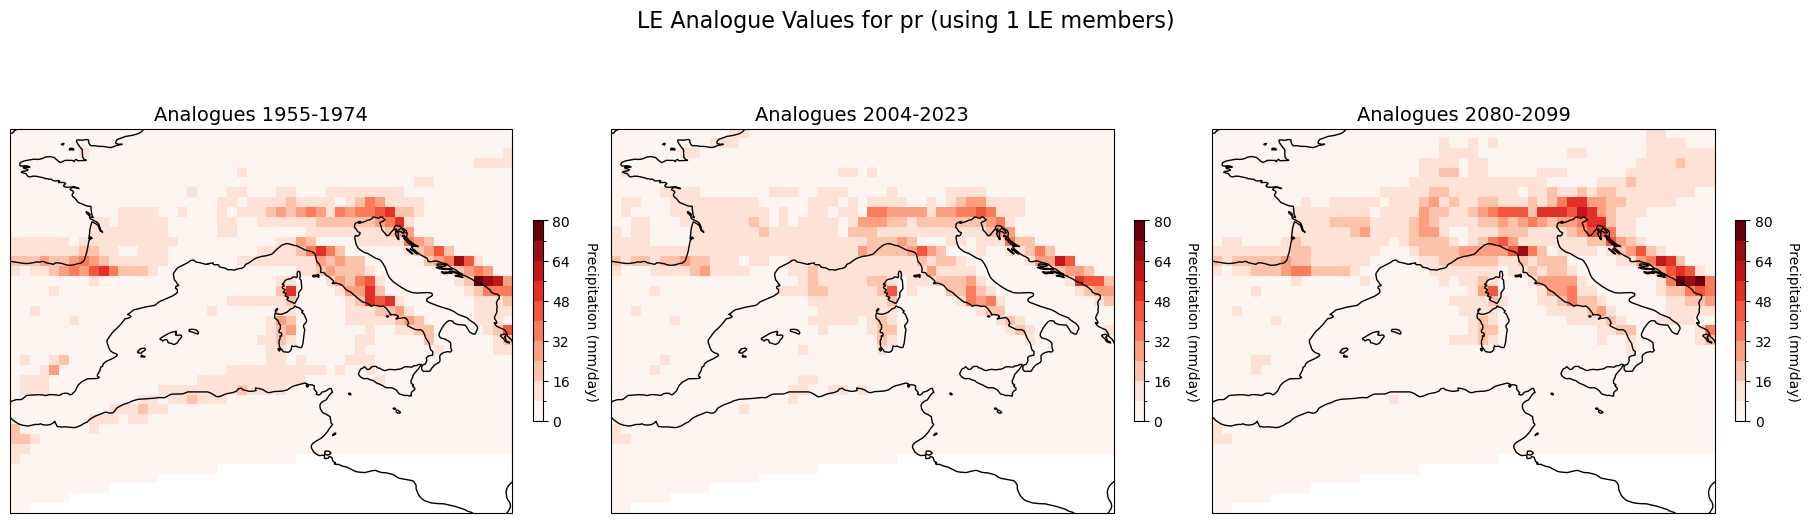

In [61]:
# Create subplots with Cartopy projection
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(18, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)
axes = axes.flatten()

# Colormap and normalization
# Define discrete color levels (e.g., 5 bins from -10 to 10)
if varname == 'psl':
    bounds = np.arange(-24, 25, 3)  # Bin edges for geopotential height differences
    units = 'hPa'
elif varname == 'zg':
    bounds = np.arange(-15,16,2)  # Bin edges
    units = 'm'
elif varname == 'pr':
    bounds = np.arange(0,81,8)
    units = 'mm/day'
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

# Define a discrete colormap (must match number of bins)
if varname == 'pr':
    cmap = plt.get_cmap('Reds', len(bounds) - 1)  # E.g., 6 discrete colors for precipitation
else:
    cmap = plt.get_cmap('RdBu_r', len(bounds) - 1)  # E.g., 6 discrete colors

# Plot each dataset
for i in range(len(list_ds_anom)):
    ax = axes[i]
    ds_anom = list_ds_anom[i][varname].squeeze()  # Extract the variable from the dataset

    # Plot assuming ds_anom is 2D (lat, lon)
    if varname == 'zg':
        ds_anom *= 9.8  # Convert geopotential to height
    elif varname == 'pr':
        ds_anom *= 3600  # Convert precipitation from m/s*24 to mm/day
    im = ds_anom.plot.imshow(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    # Add map features
    ax.coastlines()
    ax.set_title(f"Analogues {list_year_ranges[i][0]}-{list_year_ranges[i][1]}", fontsize=14)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    if varname=='pr':
        cbar.set_label(f'Precipitation ({units})', rotation=270, labelpad=20)
        fig.suptitle(f"LE Analogue Values for {varname} (using {no_membs} LE members)", fontsize=16)
    else:
        cbar.set_label(f'Anomaly ({units})', rotation=270, labelpad=20)
        fig.suptitle(f"LE Analogue Anomalies for {varname} (using {no_membs} LE members)", fontsize=16)

# Show plot
plt.show()

# Save the figure
fig.savefig(f"{fig_dir}{varname}_analogue-anomalies-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs_sign.png", bbox_inches='tight', dpi=300)

### Plot analogue precipitation (regional average in mask) 

In [62]:
# Upload precipitation value in region
diff_dir = './analogue_data/analogue_differences/'
factor = 3600
reg_precip = []  # Initialize list to store regional precipitation values
for year_range in list_year_ranges:
    # Load the precipitation data for the specified year range
    input_file = f'{diff_dir}analogues-{var_analogues}_mask-mean-{varname}_{str_event}_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5_{no_membs}membs.nc'
    reg_precip.append(xr.open_dataset(input_file)[varname].values.flatten()* factor)


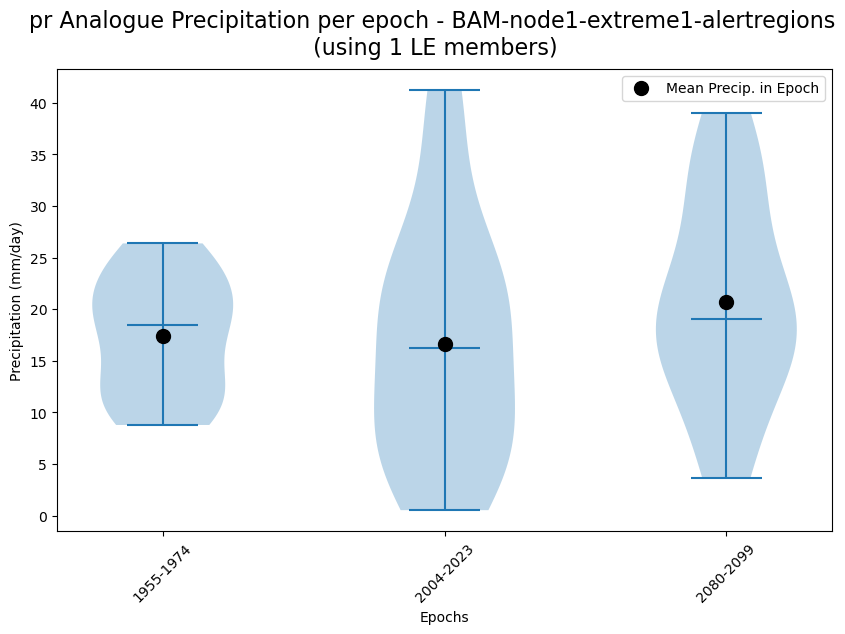

In [63]:
# Plot violin plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
fig.suptitle(f"{varname} Analogue Precipitation per epoch - {str_event}\n (using {no_membs} LE members)", fontsize=16)  
# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]
# Plot violin per epoch   
reg_precip_clean = [np.array(x)[~np.isnan(x)] for x in reg_precip]
ax.violinplot(reg_precip_clean, showmeans=False, showmedians=True, showextrema=True)
# Plot the mean precipitation for the epoch
ax.plot(np.arange(1, len(reg_precip) + 1), [np.nanmean(reg_precip[i]) for i in range(len(reg_precip))], marker='o', color='black', markersize=10, label=f'Mean Precip. in Epoch', linewidth=0)     
# Ticks and labels
ax.set_xticks(range(1, len(list_year_ranges) + 1))
ax.set_xticklabels(list_epoch_str, rotation=45)
ax.set_xlabel('Epochs')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend() 

plt.show()

# Save the figure
fig.savefig(f"{fig_dir}{varname}_mask-mean_analogues-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs_sign.png", bbox_inches='tight', dpi=300)